In [161]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import math
# importing all the necessary libraries for numerical computations, tabular structure, plotting, etc.


In [162]:
data = []
file = open('chainAdata.pdb')  # This is the file containing the data only about chain 'A' in the protein '1e65'
for line in file:
    data.append(line.split())
file.close()    
data.pop(0) 
# storing the chain A related lines in a list called "data" where each element is a list of data points in a row(or maybe line in this context)


[]

In [163]:
atom = []
residue = []
residue_number = []
x_coord = []
y_coord = []
z_coord = []
specific_atom = []
for item in data:   # iterating through the list of lists "data" and storing respective values in the new created lists, which will be columns  of the table later
    atom.append(item[-1])
    residue.append(item[3])
    residue_number.append(int(item[5]))
    specific_atom.append(item[2])
    x_coord.append(float(item[6]))
    y_coord.append(float(item[7]))
    z_coord.append(float(item[8]))


In [164]:
new = pd.DataFrame({'atom': atom, 'specific_atom': specific_atom, 'residue':residue, 'residue_number':residue_number, 'x_coord':x_coord, 'y_coord':y_coord, 'z_coord':z_coord}) 
# creating a table with these columns

In [165]:
new       # This is the table  containing all our necessary information about A chain of protein

,atom,specific_atom,residue,residue_number,x_coord,y_coord,z_coord
0,N,N,ALA,1,-9.065,52.692,26.391
1,C,CA,ALA,1,-10.128,53.670,26.230
2,C,C,ALA,1,-10.467,53.705,24.737
3,O,O,ALA,1,-9.933,52.859,24.001
4,C,CB,ALA,1,-9.664,55.066,26.678
...,...,...,...,...,...,...,...
969,C,CG,LYS,128,-9.817,43.856,19.176
970,C,CD,LYS,128,-10.665,43.307,20.314
971,C,CE,LYS,128,-11.452,44.445,20.953
972,N,NZ,LYS,128,-12.025,44.020,22.218


Question-1
Calculating the pairwise interaction energy among all pairs of charged residues(at pH = 7) and constructing a square matrix likewise

In [166]:
def pairwise_interactionenergy_ph(new,ph,absolute):  # defining a function to find pairwise energy matrix at a general ph
    req = ['GLU', 'ASP', 'LYS', 'ARG', 'HIS','TYR','CYS']
    charge = ['N', 'O','S']
    # these are the residues whose side chains can be charged and charge can only be present on atoms like N,O,S

    energy_data = new[new['residue'].isin(req) & new['atom'].isin(charge)]
    # filtering out uncharged residues and other atoms....
    
    lysine = ['NZ']
    arginine = ['NE','NH1','NH2']
    histidine = ['ND1','NE2']
    glutamic_acid = ['OE1','OE2']
    aspartic_acid = ['OD1','OD2']
    tyrosine = ['OH']
    cysteine = ['SG']
    
    # These are the specific_atoms in the residue where the charge is present(delocalized in some cases)


    charge_values = {
        "7": [1, 1/3, 0, -1/2, -1/2,0,0],
        "2": [1, 1/3, 1/2, 0,0,0,0],
        "5": [1, 1/3, 1/2, -1/2, -1/2,0,0],
        "14": [0, 0, 0, -1/2, -1/2,-1,-1]
        }
    # These are the values of the charges at different ph values with respect to the 7 residues list given above
    # example: at ph 7, 1/3 means all the specific_atoms in the list of "arginine" will have the charge value +1/3

    charge_conditions = [
        (energy_data['specific_atom'].isin(lysine)
        & energy_data['residue'].isin(['LYS'])),
        (energy_data['specific_atom'].isin(arginine)
     & energy_data['residue'].isin(['ARG'])),
    (energy_data['specific_atom'].isin(histidine)
     & energy_data['residue'].isin(['HIS'])),
    (energy_data['specific_atom'].isin(glutamic_acid)
     & energy_data['residue'].isin(['GLU'])),
    (energy_data['specific_atom'].isin(aspartic_acid)
     & energy_data['residue'].isin(['ASP'])),
    (energy_data['specific_atom'].isin(tyrosine)
        & energy_data['residue'].isin(['TYR'])),
    (energy_data['specific_atom'].isin(cysteine)
        & energy_data['residue'].isin(['CYS']))
]
    energy_data['charge'] = np.select(charge_conditions, charge_values[ph]);
    # This will add a column name "charge" to energy_data which will have respective values of the charge at a given ph
    
    energy_data = energy_data[energy_data['charge'] != 0]
    #filtering out the residues with no charge
    
    iterative_list = energy_data.index.tolist()
    # creating a list of indices  in order to access the rows of the table "energy_data"
    
    def interaction_energy(q1, q2, x1, y1, z1, x2, y2, z2):
        k = 9*(10**9)/78      # dividing by 78 because of the dielectric constant
        e = 1.66 * (10**(-19))
        q1 = q1*e
        q2 = q2*e
        r = 10**(-10) * (((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
                        )**(1/2)  # because the units are angstroms
        energy = k*q1*q2/r
        return energy*(6*(10**(18)))*(10**3)

    # creating a function for interaction energy where input is charge of atom1, charge of atom2 and coordinates of those atoms
    # output is the interaction energy between the two atoms in  milli electron volts(meV)
    
    
    
    matrix = []
    for i in iterative_list:
        for j in iterative_list:
            if j == i:
                matrix.append(0)
            else:
                if absolute == True:  # Incase, if we only require the magnitude of the interaction energy
                    matrix.append(abs(interaction_energy(energy_data['charge'][i], energy_data['charge'][j], energy_data['x_coord'][i], energy_data['y_coord']
                                                     [i], energy_data['z_coord'][i], energy_data['x_coord'][j], energy_data['y_coord'][j], energy_data['z_coord'][j])))
                else:
                    matrix.append(interaction_energy(energy_data['charge'][i], energy_data['charge'][j], energy_data['x_coord'][i], energy_data['y_coord']
                                                     [i], energy_data['z_coord'][i], energy_data['x_coord'][j], energy_data['y_coord'][j], energy_data['z_coord'][j]))
                
    # calculating all the pairwise interaction energies and storing it in "matrix" array
    
    matrix = np.reshape(matrix, (len(iterative_list), len(iterative_list)))
    # converting an array into square matrix


    headers = []
    for i in iterative_list:
        s = f'{energy_data["residue"][i]}_{energy_data["residue_number"][i]}_{energy_data["specific_atom"][i]}'
        headers.append(s)
    # header is named as "residue_residuenumber_specificatom" in order to identify the interactions in the matrix

    energy_matrix = pd.DataFrame(matrix, index=headers, columns=headers)
    
    return energy_matrix


In [167]:
energy_matrix_ph7 = pairwise_interactionenergy_ph(new,"7",absolute=False)
energy_matrix_ph7
# calculating the pairwise interaction energy(in milli eV) matrix at ph = 7

,GLU_2_OE1,GLU_2_OE2,ASP_6_OD1,ASP_6_OD2,ASP_11_OD1,ASP_11_OD2,ASP_23_OD1,ASP_23_OD2,LYS_24_NZ,LYS_27_NZ,...,ASP_98_OD1,ASP_98_OD2,LYS_101_NZ,LYS_103_NZ,GLU_104_OE1,GLU_104_OE2,GLU_106_OE1,GLU_106_OE2,LYS_122_NZ,LYS_128_NZ
GLU_2_OE1,0.000000,22.059509,4.004393,3.853121,1.557661,1.486591,4.301513,5.026637,-5.409086,-9.047958,...,3.360333,2.934287,-4.942017,-3.606190,2.535177,2.485649,2.007898,1.846408,-3.179073,-7.098408
GLU_2_OE2,22.059509,0.000000,3.536124,3.480159,1.481680,1.420039,4.417065,5.188129,-5.434603,-8.916689,...,3.008692,2.659325,-4.523682,-3.482351,2.498396,2.467051,1.917478,1.769659,-3.060754,-7.282947
ASP_6_OD1,4.004393,3.536124,0.000000,22.227017,2.527315,2.352912,2.709418,2.772178,-3.890546,-4.640304,...,2.678801,2.506571,-4.837842,-3.342836,2.054584,1.941487,1.949154,1.827932,-4.149447,-5.559771
ASP_6_OD2,3.853121,3.480159,22.227017,0.000000,2.512311,2.361828,2.622757,2.670670,-3.733441,-4.401463,...,2.421561,2.271088,-4.375172,-3.159580,1.960910,1.857790,1.825384,1.719356,-4.031111,-5.503822
ASP_11_OD1,1.557661,1.481680,2.527315,2.512311,0.000000,21.909988,1.439335,1.422490,-2.465807,-2.521207,...,1.504985,1.501076,-3.204928,-2.582677,1.346836,1.276573,1.473471,1.450152,-4.964295,-3.066894
ASP_11_OD2,1.486591,1.420039,2.352912,2.361828,21.909988,0.000000,1.375640,1.358917,-2.359453,-2.408805,...,1.415204,1.409623,-2.990643,-2.450810,1.283488,1.219138,1.388526,1.368354,-4.666875,-2.940124
ASP_23_OD1,4.301513,4.417065,2.709418,2.622757,1.439335,1.375640,0.000000,22.168451,-11.070714,-8.360675,...,2.891997,2.667509,-4.848365,-4.868085,5.155313,4.919704,2.720695,2.460487,-3.720453,-18.856333
ASP_23_OD2,5.026637,5.188129,2.772178,2.670670,1.422490,1.358917,22.168451,0.000000,-10.684800,-10.126034,...,3.145270,2.854857,-5.038297,-4.750724,4.639922,4.553934,2.635574,2.377647,-3.532667,-13.812618
LYS_24_NZ,-5.409086,-5.434603,-3.890546,-3.733441,-2.465807,-2.359453,-11.070714,-10.684800,0.000000,15.987059,...,-5.695207,-5.461768,10.078607,13.527140,-19.235857,-29.419133,-6.780457,-6.065318,6.735528,15.564539
LYS_27_NZ,-9.047958,-8.916689,-4.640304,-4.401463,-2.521207,-2.408805,-8.360675,-10.126034,15.987059,0.000000,...,-8.811588,-7.570445,11.542574,9.000920,-6.338714,-6.654843,-4.718312,-4.269966,5.702960,11.701490


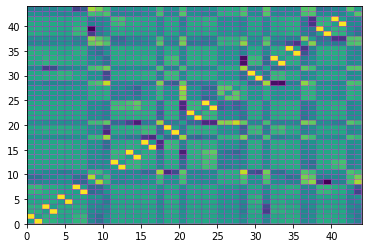

In [168]:
# equivalent of the pcolor function used in matlab
plt.pcolor(energy_matrix_ph7, edgecolors='m');
# at ph = 7

Question 2: Finding interaction_energy matrices at ph = 2,5,14



In [169]:
energy_matrix_ph2 = pairwise_interactionenergy_ph(new, "2",absolute=True)
energy_matrix_ph5 = pairwise_interactionenergy_ph(new, "5",absolute=True)
energy_matrix_ph14 = pairwise_interactionenergy_ph(new, "14",absolute=True)


# here we are only interested in magnitude of the interactions therefore we set absolute = True
# the actual interaction energy matrix is can be seen by changing absolute=False in the last argument

In [170]:
energy_matrix_ph2  # interaction energy matrix at ph = 2


,LYS_24_NZ,LYS_27_NZ,HIS_35_ND1,HIS_35_NE2,LYS_41_NZ,HIS_46_ND1,HIS_46_NE2,LYS_70_NZ,LYS_74_NZ,ARG_79_NE,...,HIS_83_ND1,HIS_83_NE2,LYS_85_NZ,LYS_92_NZ,LYS_101_NZ,LYS_103_NZ,HIS_117_ND1,HIS_117_NE2,LYS_122_NZ,LYS_128_NZ
LYS_24_NZ,0.000000,15.987059,2.667900,2.645994,4.982931,2.885502,2.843569,4.883675,6.225968,2.382144,...,3.483290,3.535897,6.368077,6.687796,10.078607,13.527140,2.686752,2.551877,6.735528,15.564539
LYS_27_NZ,15.987059,0.000000,2.776626,2.736519,5.364528,2.879580,2.853271,5.088239,5.889705,2.147311,...,3.720063,3.801081,7.499722,7.811394,11.542574,9.000920,2.594664,2.456698,5.702960,11.701490
HIS_35_ND1,2.667900,2.776626,0.000000,22.402809,7.791454,8.266236,11.223979,4.057048,3.533374,1.236585,...,2.857451,2.534645,5.859628,8.164074,3.608123,2.775688,4.881240,4.320130,5.069250,3.339963
HIS_35_NE2,2.645994,2.736519,22.402809,0.000000,8.935447,10.376689,12.720847,4.401040,3.753862,1.306065,...,3.049561,2.685232,6.075292,7.408710,3.676995,2.820465,5.799938,5.049144,5.190610,3.241585
LYS_41_NZ,4.982931,5.364528,7.791454,8.935447,0.000000,8.022213,7.353666,15.008382,9.173564,2.926281,...,8.022754,7.149835,17.525886,11.220476,8.207370,5.653409,7.012163,6.619802,7.756079,5.498549
HIS_46_ND1,2.885502,2.879580,8.266236,10.376689,8.022213,0.000000,22.354406,4.639865,4.307010,1.545497,...,3.501829,3.033805,6.104517,6.903021,4.045769,3.183672,9.460671,6.879856,6.752605,3.529113
HIS_46_NE2,2.843569,2.853271,11.223979,12.720847,7.353666,22.354406,0.000000,4.250487,3.939636,1.411641,...,3.138846,2.753693,5.761411,7.289609,3.844403,3.051732,7.524495,5.962641,6.483823,3.560138
LYS_70_NZ,4.883675,5.088239,4.057048,4.401040,15.008382,4.639865,4.250487,0.000000,14.944145,3.902255,...,7.245663,7.438122,12.153545,7.183752,8.808938,6.245475,4.720609,4.618583,6.767205,4.859960
LYS_74_NZ,6.225968,5.889705,3.533374,3.753862,9.173564,4.307010,3.939636,14.944145,0.000000,13.141613,...,7.202040,7.801815,9.801702,6.733376,11.582930,9.824300,4.476558,4.315992,8.345686,5.751238
ARG_79_NE,2.382144,2.147311,1.236585,1.306065,2.926281,1.545497,1.411641,3.902255,13.141613,0.000000,...,2.496973,2.646598,3.259585,2.398083,4.283374,4.067753,1.594973,1.517757,3.321994,2.195241


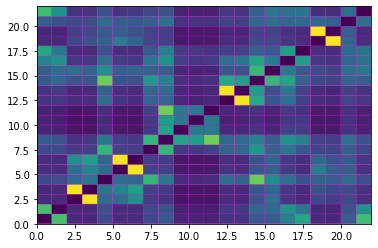

In [171]:
plt.pcolor(energy_matrix_ph2, edgecolors='m');

In [172]:
energy_matrix_ph5
# interaction energy matrix at ph = 5


,GLU_2_OE1,GLU_2_OE2,ASP_6_OD1,ASP_6_OD2,ASP_11_OD1,ASP_11_OD2,ASP_23_OD1,ASP_23_OD2,LYS_24_NZ,LYS_27_NZ,...,LYS_101_NZ,LYS_103_NZ,GLU_104_OE1,GLU_104_OE2,GLU_106_OE1,GLU_106_OE2,HIS_117_ND1,HIS_117_NE2,LYS_122_NZ,LYS_128_NZ
GLU_2_OE1,0.000000,22.059509,4.004393,3.853121,1.557661,1.486591,4.301513,5.026637,5.409086,9.047958,...,4.942017,3.606190,2.535177,2.485649,2.007898,1.846408,1.498943,1.406571,3.179073,7.098408
GLU_2_OE2,22.059509,0.000000,3.536124,3.480159,1.481680,1.420039,4.417065,5.188129,5.434603,8.916689,...,4.523682,3.482351,2.498396,2.467051,1.917478,1.769659,1.423903,1.340593,3.060754,7.282947
ASP_6_OD1,4.004393,3.536124,0.000000,22.227017,2.527315,2.352912,2.709418,2.772178,3.890546,4.640304,...,4.837842,3.342836,2.054584,1.941487,1.949154,1.827932,2.211020,2.022674,4.149447,5.559771
ASP_6_OD2,3.853121,3.480159,22.227017,0.000000,2.512311,2.361828,2.622757,2.670670,3.733441,4.401463,...,4.375172,3.159580,1.960910,1.857790,1.825384,1.719356,2.130466,1.959274,4.031111,5.503822
ASP_11_OD1,1.557661,1.481680,2.527315,2.512311,0.000000,21.909988,1.439335,1.422490,2.465807,2.521207,...,3.204928,2.582677,1.346836,1.276573,1.473471,1.450152,5.025022,4.710483,4.964295,3.066894
ASP_11_OD2,1.486591,1.420039,2.352912,2.361828,21.909988,0.000000,1.375640,1.358917,2.359453,2.408805,...,2.990643,2.450810,1.283488,1.219138,1.388526,1.368354,4.326154,4.195780,4.666875,2.940124
ASP_23_OD1,4.301513,4.417065,2.709418,2.622757,1.439335,1.375640,0.000000,22.168451,11.070714,8.360675,...,4.848365,4.868085,5.155313,4.919704,2.720695,2.460487,1.500338,1.412468,3.720453,18.856333
ASP_23_OD2,5.026637,5.188129,2.772178,2.670670,1.422490,1.358917,22.168451,0.000000,10.684800,10.126034,...,5.038297,4.750724,4.639922,4.553934,2.635574,2.377647,1.470363,1.384305,3.532667,13.812618
LYS_24_NZ,5.409086,5.434603,3.890546,3.733441,2.465807,2.359453,11.070714,10.684800,0.000000,15.987059,...,10.078607,13.527140,19.235857,29.419133,6.780457,6.065318,2.686752,2.551877,6.735528,15.564539
LYS_27_NZ,9.047958,8.916689,4.640304,4.401463,2.521207,2.408805,8.360675,10.126034,15.987059,0.000000,...,11.542574,9.000920,6.338714,6.654843,4.718312,4.269966,2.594664,2.456698,5.702960,11.701490


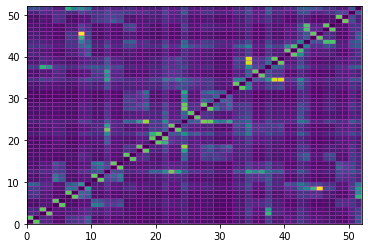

In [173]:
plt.pcolor(energy_matrix_ph5,edgecolors = 'm');


In [174]:
energy_matrix_ph14
# interaction energy matrix at ph = 14


,GLU_2_OE1,GLU_2_OE2,CYS_3_SG,ASP_6_OD1,ASP_6_OD2,ASP_11_OD1,ASP_11_OD2,ASP_23_OD1,ASP_23_OD2,CYS_26_SG,...,ASP_93_OD1,ASP_93_OD2,ASP_98_OD1,ASP_98_OD2,GLU_104_OE1,GLU_104_OE2,GLU_106_OE1,GLU_106_OE2,TYR_108_OH,CYS_112_SG
GLU_2_OE1,0.000000,22.059509,19.497799,4.004393,3.853121,1.557661,1.486591,4.301513,5.026637,13.968897,...,2.364991,2.274235,3.360333,2.934287,2.535177,2.485649,2.007898,1.846408,4.532821,3.485038
GLU_2_OE2,22.059509,0.000000,15.747611,3.536124,3.480159,1.481680,1.420039,4.417065,5.188129,12.313868,...,2.140831,2.066585,3.008692,2.659325,2.498396,2.467051,1.917478,1.769659,4.307174,3.273020
CYS_3_SG,19.497799,15.747611,0.000000,7.690428,7.118618,3.192293,3.026009,12.189611,15.095802,94.169641,...,4.949962,4.863624,8.475951,7.278555,6.690347,6.458953,5.046615,4.545812,11.786551,7.650468
ASP_6_OD1,4.004393,3.536124,7.690428,0.000000,22.227017,2.527315,2.352912,2.709418,2.772178,7.165525,...,3.911084,3.693426,2.678801,2.506571,2.054584,1.941487,1.949154,1.827932,4.316730,5.323860
ASP_6_OD2,3.853121,3.480159,7.118618,22.227017,0.000000,2.512311,2.361828,2.622757,2.670670,6.634972,...,3.418716,3.239162,2.421561,2.271088,1.960910,1.857790,1.825384,1.719356,4.021778,4.990977
ASP_11_OD1,1.557661,1.481680,3.192293,2.527315,2.512311,0.000000,21.909988,1.439335,1.422490,3.176904,...,2.743914,2.845868,1.504985,1.501076,1.346836,1.276573,1.473471,1.450152,3.056288,8.246983
ASP_11_OD2,1.486591,1.420039,3.026009,2.352912,2.361828,21.909988,0.000000,1.375640,1.358917,3.008642,...,2.468999,2.537774,1.415204,1.409623,1.283488,1.219138,1.388526,1.368354,2.875471,7.018733
ASP_23_OD1,4.301513,4.417065,12.189611,2.709418,2.622757,1.439335,1.375640,0.000000,22.168451,14.869400,...,1.881756,1.890370,2.891997,2.667509,5.155313,4.919704,2.720695,2.460487,6.385373,3.467189
ASP_23_OD2,5.026637,5.188129,15.095802,2.772178,2.670670,1.422490,1.358917,22.168451,0.000000,18.615069,...,1.928221,1.926452,3.145270,2.854857,4.639922,4.553934,2.635574,2.377647,6.170098,3.408088
CYS_26_SG,13.968897,12.313868,94.169641,7.165525,6.634972,3.176904,3.008642,14.869400,18.615069,0.000000,...,4.817735,4.786303,8.554780,7.442626,7.781809,7.428370,5.567631,4.966738,13.247214,7.794877


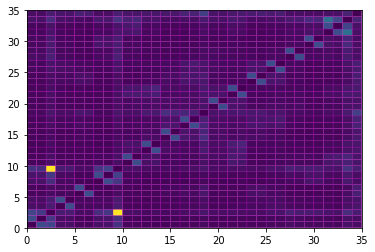

In [175]:
plt.pcolor(energy_matrix_ph14, edgecolors='m');

In [176]:
energy_matrix_ph2 = pairwise_interactionenergy_ph(new, "2", absolute=False)
energy_matrix_ph5 = pairwise_interactionenergy_ph(new, "5", absolute=False)
energy_matrix_ph14 = pairwise_interactionenergy_ph(new, "14", absolute=False)


# we need actual values of energy for total energy calculation purpose

In [177]:
def total_energy(energy_matrix):
    total_energy = 0
    for i in energy_matrix.index:
        for j in energy_matrix.columns:
            total_energy = total_energy + energy_matrix[i][j]
    return total_energy
# calculating the total energy of the protein(in milli eV)

In [178]:
print(total_energy(energy_matrix_ph7))
print(total_energy(energy_matrix_ph2))
print(total_energy(energy_matrix_ph5))
print(total_energy(energy_matrix_ph14))

-212.0572663516783
2696.090218784805
-180.0510447418135
4909.660128433178


In [179]:
# It is clearly seen that, 1) at pH = 7, total energy of the system is least, Therefore this is the most stable form of protein
# 2) Since, the total energy of the protein is increasing at any another pH, we can say that the protein is getting destabilized at pH = 2,5 and 14                    

Question 3: pI of the protein

In [180]:
res_list = []
file  = open('residue_seq.txt')
for line in file:
        line = line.split()
        res_list.extend(line)
file.close()        
     

# taking all the residues of the chain A of protein in "res_list" sequentially

In [181]:
pka_values ={
  'N_one': 8.6,
  'ASP' : 3.9,
  'GLU' : 4.25,
  'LYS' : 10.8,
  'ARG' : 12.5,
  'HIS' : 6.04,
  'CYS' : 8.5,
  'TYR' : 10.1,
  'C_last' : 3.6
}
# the pka values of side chains of amino acids
# the N_one and C_last are the pka values of the corner parts of the complete residue sequence
res_list.insert(0, 'N_one')
res_list.append('C_last')

res_list = list(filter(lambda x: x in pka_values.keys(), res_list))
 
# filtering the residues which are present in the pka_values dictionary    
    


In [182]:
# we know that the net charge of protein is -ve at pH = 14

In [183]:
charge = []
ph = 14
while ph >= 0:
    net_charge = 0
    for i in res_list:
        if pka_values[i] < ph:
            net_charge += -1
        elif pka_values[i] > ph:
            net_charge += 1
        else:
            pass
    charge.append(net_charge)    
    if net_charge >= 0:
        print(ph)
    ph -= 0.01
                    
# Here, we want to calculate the pH at which the net charge of protein is changing from -ve to +ve    
# To calculate the net charge, we use the inner for loop which checks the pka value of residue with current pH value
# we know that, if pH is greater than pka of residue, then it will lose H+. hence -ve charge and vice versa

6.03000000000017
6.02000000000017
6.01000000000017
6.0000000000001705
5.990000000000171
5.980000000000171
5.970000000000171
5.960000000000171
5.950000000000172
5.940000000000172
5.930000000000172
5.920000000000172
5.9100000000001724
5.900000000000173
5.890000000000173
5.880000000000173
5.870000000000173
5.8600000000001735
5.850000000000174
5.840000000000174
5.830000000000174
5.820000000000174
5.810000000000175
5.800000000000175
5.790000000000175
5.780000000000175
5.770000000000175
5.760000000000176
5.750000000000176
5.740000000000176
5.730000000000176
5.7200000000001765
5.710000000000177
5.700000000000177
5.690000000000177
5.680000000000177
5.670000000000178
5.660000000000178
5.650000000000178
5.640000000000178
5.630000000000178
5.620000000000179
5.610000000000179
5.600000000000179
5.590000000000179
5.5800000000001795
5.57000000000018
5.56000000000018
5.55000000000018
5.54000000000018
5.5300000000001805
5.520000000000181
5.510000000000181
5.500000000000181
5.490000000000181
5.480000000

In [184]:
# This is the pH(6.03000000000017) at which net charge changes the sign from -ve to +ve
# So, let us consider residues with pka_values just above and below the pH value of interest(6.030000000000021)
# these are histidine and glutamic acid.


In [185]:
glu_count = 0
his_count = 0
for i in res_list:
    if i == 'GLU':
        glu_count += 1
    elif i == 'HIS':
        his_count += 1
    else:
        pass

# calculating pI is now just the mean of these values
# but we should also account for number of occurences each of the residues have.

pI = (glu_count*4.25 + his_count*6.04)/(his_count+glu_count)        
# calculating pI


In [186]:
print(pI)

5.145


In [187]:
# The answer might slightly differ from the correct answer
# because of the pka values that we have taken. Different sites showed us different pka values.

Question 4: Constructing pH titration curves of every residue

In [188]:
pH = np.arange(14,-0.01,-0.01)

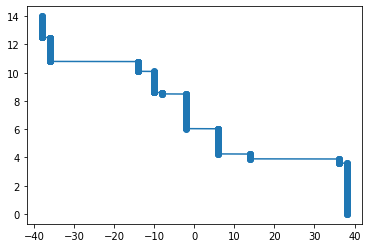

In [191]:

plt.plot(charge, pH,'-o');